In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import to_categorical
from keras.callbacks.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import fowlkes_mallows_score
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Spatio temporal/STData.csv"
df_long = pd.read_csv(path)
df_long = df_long.replace([np.inf, -np.inf], np.nan)
st1 = pd.read_csv("/content/drive/My Drive/Spatio temporal/STData_1.csv")
st1 = st1.replace([np.inf, -np.inf], np.nan)

In [0]:
g = st1.groupby("id", as_index = False)
print(g.ngroups)

1000


In [0]:
def get_xy_tensors(data, timestep):

    data.dropna(inplace = True)
    groupedpp = data.groupby("id", as_index = False)
    n = groupedpp.ngroups

    indices = np.arange(n)
    np.random.shuffle(indices)
    split = int(np.floor(n * 0.8))

    train_vis, test_vis = [], []

    array_train = np.zeros(shape = (split, timestep, 2))
    array_test = np.zeros(shape = (n - split, timestep, 2))

    train_index, test_index = 0, 0

    groundtruth_train, groundtruth_test = [], []

    scaler = StandardScaler().fit(data[["X", "Y"]])
    
    for i, df in zip(indices, groupedpp):
      X = scaler.transform(df[1][["X", "Y"]])
      truth = df[1].reset_index(drop = True).at[0, "group"]

      if i < split:
        array_train[train_index,:len(X),:] = X
        groundtruth_train.append(truth)
        train_vis.append(df[1])
        train_index += 1
      else:
        array_test[test_index,:len(X),:] = X
        groundtruth_test.append(truth)
        test_vis.append(df[1])
        test_index += 1
    return array_train, array_test, groundtruth_train, groundtruth_test, pd.concat(train_vis, ignore_index=True), pd.concat(test_vis, ignore_index=True)

In [0]:
def shift_array(array):
  arr = np.zeros_like(array)
  a,b,c = arr.shape
  arr[:,:b-1,:] = array[:,1:,:]
  return arr

In [0]:
xy_long_train, xy_long_test, gt_train, gg_test, trainv, testv = get_xy_tensors(df_long, 50)


In [0]:
def simple_lstm(time_dim, hidden_dim1, hidden_dim2, features, active):
    #Inputs
    encoder_input = Input(shape = (time_dim, features))
    
    #Put together encoder
    encoded1 = LSTM(hidden_dim1, return_sequences = True, activation= active)(encoder_input)
    encoded2 = LSTM(hidden_dim2, return_sequences = False, activation = active)(encoded1)
    #This generates the encoding vectors to use for clustering
    #encoded3 = LSTM(hidden_dim3, return_sequences = False)(encoded2)
        
    #format encoder output for the decoder input
    decoded = RepeatVector(time_dim)(encoded2)
    
    #Decoder is the inverse of the encoder
    #decoded1 = LSTM(hidden_dim3, return_sequences = True)(decoded)
    decoded2 = LSTM(hidden_dim2, return_sequences = True, activation = active)(decoded)
    decoded3 = LSTM(hidden_dim1, return_sequences = True, activation = active)(decoded2)
    
    #applies dense layer (shape becomes the same as output) independently to each timestep
    decoded4 = TimeDistributed(Dense(features))(decoded3)
    
    #autoencoder
    autoencoder = Model(encoder_input, decoded4)
    #encoder
    encoder = Model(encoder_input, encoded2)
    
    return autoencoder, encoder

In [0]:
def plot_clusters(data, labels, cluster, ax = None):
  ax = ax
  groupedpp = data.groupby("id")
  index = np.arange(groupedpp.ngroups)
  for i, df in zip(index, groupedpp):
    if labels[i] == cluster:
      ax.plot(df[1]["X"], df[1]["Y"])
  return ax


In [0]:
def get_results(encoder, train, test, trainv, testv, gttrain, gttest):
  train_vecs = encoder.predict(train)
  test_vecs = encoder.predict(test)

  kfit_train = KMeans(n_clusters = 5).fit(train_vecs)
  kfit_test = KMeans(n_clusters = 5).fit(test_vecs)
  
  cluster_labels_train = kfit_train.labels_
  cluster_labels_test = kfit_test.labels_

  fscore_train = fowlkes_mallows_score(gttrain, cluster_labels_train)
  fscore_test = fowlkes_mallows_score(gttest, cluster_labels_test)

  fig, ax = plt.subplots(1,5, figsize = (20, 5))
  for i in range(5):
    plot_clusters(trainv, cluster_labels_train,i, ax[i])
  plt.tight_layout
  plt.show()

  print("fowlkes mallows score training set:",fscore_train)

  fig, ax = plt.subplots(1,5, figsize = (20, 5))
  for i in range(5):
    plot_clusters(testv, cluster_labels_test, i, ax[i])
  plt.tight_layout
  plt.show()

  print("fowlkes mallows score test set:",fscore_test)

In [0]:
autoencoder, encoder = simple_lstm(50, 128, 64, 2, "relu")

In [0]:
cb = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)
autoencoder.compile(optimizer = Adam(lr = 0.00001), loss = "mse", metrics=['accuracy'])
autoencoder.fit(xy_long_train, xy_long_train, verbose = 1, batch_size = 1000, epochs = 1000, validation_split = 0.2, callbacks=[cb])

Train on 6400 samples, validate on 1600 samples
Epoch 1/1000
6400/6400 [==============================] - 6s 999us/step - loss: 0.9845 - accuracy: 0.6770 - val_loss: 0.9955 - val_accuracy: 0.6812
Epoch 2/1000
6400/6400 [==============================] - 3s 532us/step - loss: 0.9837 - accuracy: 0.6770 - val_loss: 0.9947 - val_accuracy: 0.6812
Epoch 3/1000
6400/6400 [==============================] - 3s 524us/step - loss: 0.9829 - accuracy: 0.7219 - val_loss: 0.9938 - val_accuracy: 0.8013
Epoch 4/1000
6400/6400 [==============================] - 3s 536us/step - loss: 0.9821 - accuracy: 0.7966 - val_loss: 0.9930 - val_accuracy: 0.8018
Epoch 5/1000
6400/6400 [==============================] - 3s 536us/step - loss: 0.9812 - accuracy: 0.7928 - val_loss: 0.9921 - val_accuracy: 0.7981
Epoch 6/1000
6400/6400 [==============================] - 3s 527us/step - loss: 0.9803 - accuracy: 0.7897 - val_loss: 0.9912 - val_accuracy: 0.7950
Epoch 7/1000
6400/6400 [==============================] - 3s 537

In [0]:
autoencoder.save("lstm2autoencoderst.h5")
encoder.save("lstm2encoderst.h5")

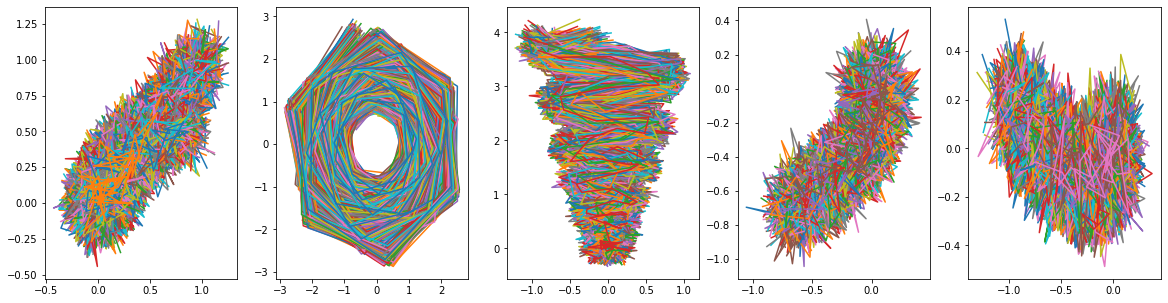

fowlkes mallows score training set: 0.7939523867841112


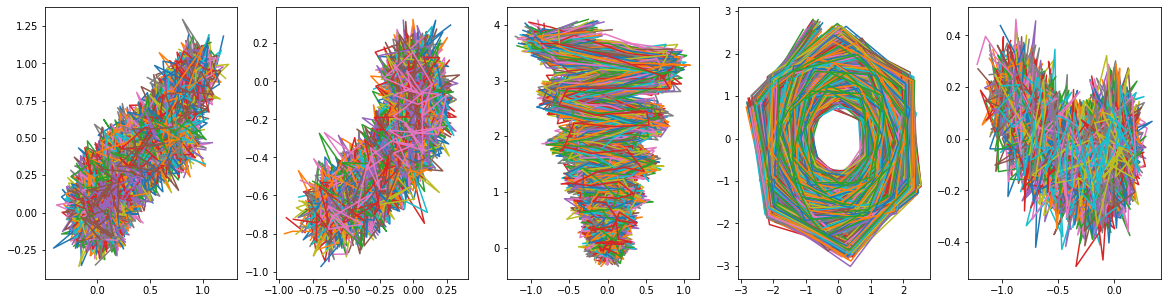

fowlkes mallows score test set: 0.7948418569392829


In [0]:
get_results(encoder, xy_long_train, xy_long_test, trainv, testv, gt_train, gg_test)

In [0]:
autoencoder1, encoder1 = simple_lstm(1000,128,64,2, "tanh")

In [0]:
xy_long_train1, xy_long_test1, gt_train1, gg_test1, trainv1, testv1 = get_xy_tensors(st1, 1000)

In [0]:
cb1 = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)
autoencoder1.compile(optimizer = Adam(lr = 0.0001), loss = "mse", metrics=['accuracy'])
autoencoder1.fit(xy_long_train1, xy_long_train1, verbose = 1, epochs = 1000, batch_size = 100, validation_split = 0.2, callbacks=[cb1])

Train on 640 samples, validate on 160 samples
Epoch 1/1000
640/640 [==============================] - 73s 114ms/step - loss: 0.9802 - accuracy: 0.7608 - val_loss: 0.9538 - val_accuracy: 0.8030
Epoch 2/1000
640/640 [==============================] - 71s 111ms/step - loss: 0.9164 - accuracy: 0.8070 - val_loss: 0.8897 - val_accuracy: 0.8047
Epoch 3/1000
640/640 [==============================] - 70s 109ms/step - loss: 0.8551 - accuracy: 0.8080 - val_loss: 0.8342 - val_accuracy: 0.8051
Epoch 4/1000
640/640 [==============================] - 71s 110ms/step - loss: 0.8156 - accuracy: 0.8082 - val_loss: 0.8248 - val_accuracy: 0.8052
Epoch 5/1000
640/640 [==============================] - 69s 108ms/step - loss: 0.8152 - accuracy: 0.8082 - val_loss: 0.8227 - val_accuracy: 0.8052
Epoch 6/1000
640/640 [==============================] - 69s 108ms/step - loss: 0.8087 - accuracy: 0.8082 - val_loss: 0.8163 - val_accuracy: 0.8052
Epoch 7/1000
640/640 [==============================] - 69s 108ms/step -

In [0]:
autoencoder1.save("lstm2autoencoderst1.h5")
encoder1.save("lstm2encoderst1.h5")

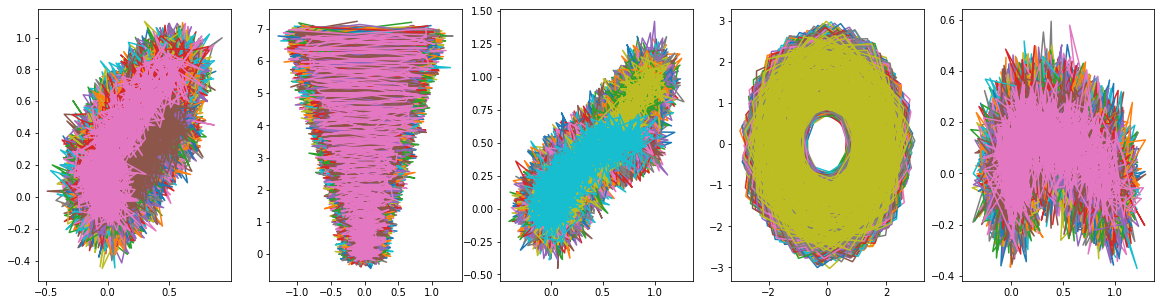

fowlkes mallows score training set: 0.7349800970245981


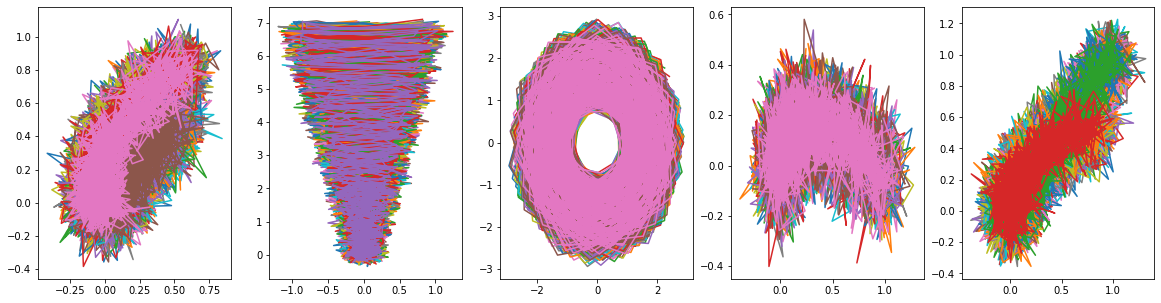

fowlkes mallows score test set: 0.7283274511547432


In [0]:
get_results(encoder1, xy_long_train1, xy_long_test1, trainv1, testv1, gt_train1, gg_test1)

In [0]:
xy_long_train_shifted = shift_array(xy_long_train)

In [0]:
autoencoder_shifted, encoder_shifted = simple_lstm(50, 128, 64, 2, "relu")

In [0]:
cb2 = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)
autoencoder_shifted.compile(optimizer = Adam(lr = 0.00001), loss = "mse", metrics=['accuracy'])
autoencoder_shifted.fit(xy_long_train, xy_long_train_shifted, verbose = 1, epochs = 1000, batch_size = 1000, validation_split = 0.2, callbacks=[cb2])

Train on 6400 samples, validate on 1600 samples
Epoch 1/1000
6400/6400 [==============================] - 5s 753us/step - loss: 0.9879 - accuracy: 0.6756 - val_loss: 0.9991 - val_accuracy: 0.6736
Epoch 2/1000
6400/6400 [==============================] - 3s 547us/step - loss: 0.9871 - accuracy: 0.6636 - val_loss: 0.9983 - val_accuracy: 0.6620
Epoch 3/1000
6400/6400 [==============================] - 3s 533us/step - loss: 0.9863 - accuracy: 0.6533 - val_loss: 0.9976 - val_accuracy: 0.6495
Epoch 4/1000
6400/6400 [==============================] - 3s 528us/step - loss: 0.9855 - accuracy: 0.6418 - val_loss: 0.9968 - val_accuracy: 0.6408
Epoch 5/1000
6400/6400 [==============================] - 3s 543us/step - loss: 0.9848 - accuracy: 0.6335 - val_loss: 0.9961 - val_accuracy: 0.6331
Epoch 6/1000
6400/6400 [==============================] - 3s 538us/step - loss: 0.9841 - accuracy: 0.6244 - val_loss: 0.9954 - val_accuracy: 0.6225
Epoch 7/1000
6400/6400 [==============================] - 3s 538

In [0]:
autoencoder_shifted.save("lstm2autoencoder_shiftedst.h5")
encoder_shifted.save("lstm2encoder_shiftedst.h5")

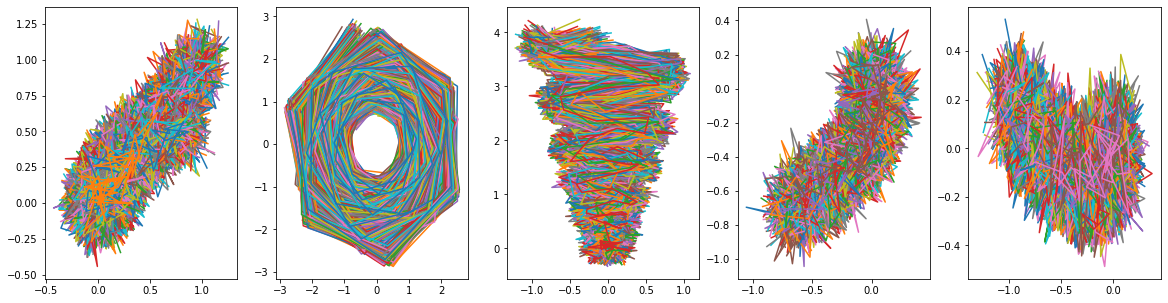

fowlkes mallows score training set: 0.7939523867841112


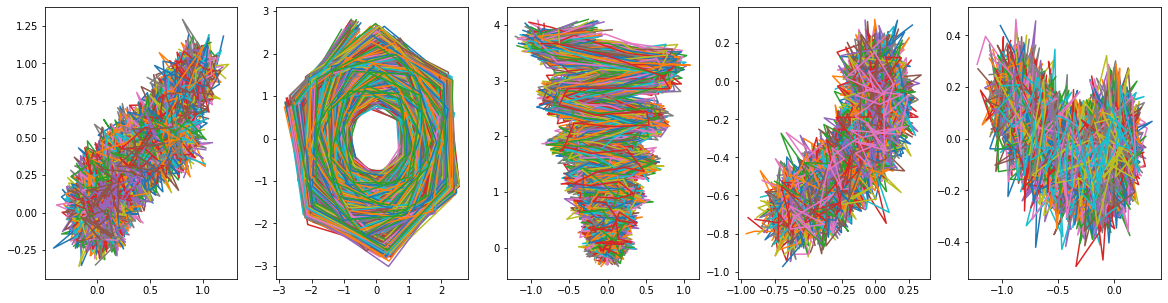

fowlkes mallows score test set: 0.7948418569392829


In [0]:
get_results(encoder_shifted, xy_long_train, xy_long_test, trainv, testv, gt_train, gg_test)

In [0]:
get_vecs = encoder.predict(xy_long_test)
get_vecs1 = encoder_shifted.predict(xy_long_test)
get_vecs == get_vecs1

array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False]])

In [0]:
kfit = KMeans(5).fit(get_vecs)
kfit1 = KMeans(5).fit(get_vecs1)
clusters = kfit.labels_
clusters1 = kfit.labels_
clusters == clusters1

array([ True,  True,  True, ...,  True,  True,  True])

In [0]:
xy_long_train_shifted1 = shift_array(xy_long_train1)

In [0]:
autoencoder1_shifted, encoder1_shifted = simple_lstm(1000,128,64,2, "tanh")

In [0]:
cb3 = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)
autoencoder1_shifted.compile(optimizer = Adam(lr = 0.0001), loss = "mse", metrics=['accuracy'])
autoencoder1_shifted.fit(xy_long_train1, xy_long_train_shifted1, verbose = 1, epochs = 1000, batch_size = 100, validation_split = 0.2, callbacks=[cb3])

Train on 640 samples, validate on 160 samples
Epoch 1/1000
640/640 [==============================] - 71s 111ms/step - loss: 0.9852 - accuracy: 0.6354 - val_loss: 0.9612 - val_accuracy: 0.8054
Epoch 2/1000
640/640 [==============================] - 70s 109ms/step - loss: 0.9258 - accuracy: 0.8084 - val_loss: 0.8992 - val_accuracy: 0.8054
Epoch 3/1000
640/640 [==============================] - 69s 108ms/step - loss: 0.8656 - accuracy: 0.8084 - val_loss: 0.8425 - val_accuracy: 0.8054
Epoch 4/1000
640/640 [==============================] - 69s 108ms/step - loss: 0.8201 - accuracy: 0.8084 - val_loss: 0.8227 - val_accuracy: 0.8054
Epoch 5/1000
640/640 [==============================] - 70s 109ms/step - loss: 0.8143 - accuracy: 0.8084 - val_loss: 0.8239 - val_accuracy: 0.8054
Epoch 6/1000
640/640 [==============================] - 70s 109ms/step - loss: 0.8101 - accuracy: 0.8084 - val_loss: 0.8163 - val_accuracy: 0.8054
Epoch 7/1000
640/640 [==============================] - 69s 107ms/step -

In [0]:
autoencoder1_shifted.save("lstm2autoencoder_shiftedst1.h5")
encoder1_shifted.save("lstm2encoder_shiftedst1.h5")

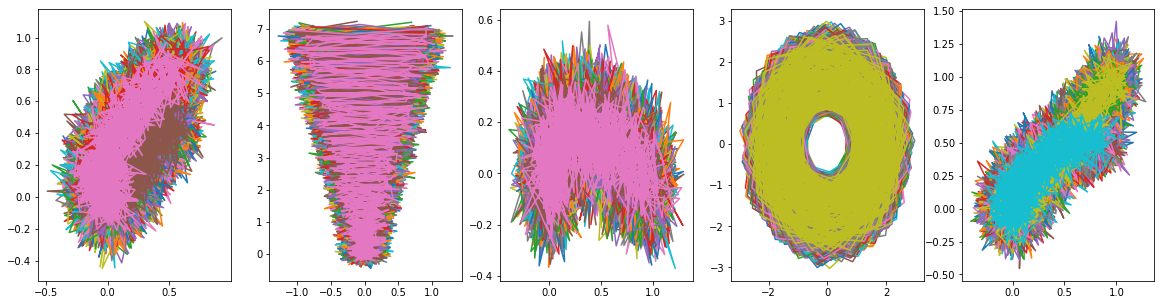

fowlkes mallows score training set: 0.7349800970245981


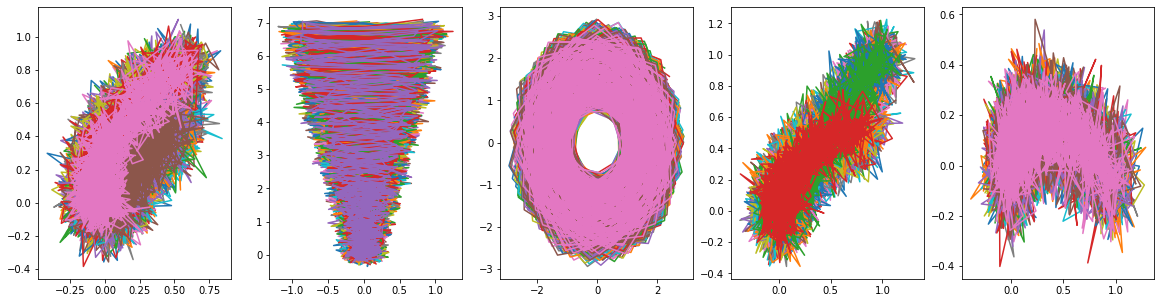

fowlkes mallows score test set: 0.7283274511547432


In [0]:
get_results(encoder1_shifted, xy_long_train1, xy_long_test1, trainv1, testv1, gt_train1, gg_test1)